In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML Models
# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split


from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Attention
from tensorflow.keras.optimizers import Adam


# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Time Series Split
from sklearn.model_selection import TimeSeriesSplit


In [3]:

def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()


In [4]:

csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [5]:

df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


In [6]:

# Define the improved LSTM model code
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Selecting features and target variable
features = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20",
            "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

# Handling missing values by interpolation
df.fillna(method='ffill', inplace=True)


## LSTM

In [7]:

# Scaling the data using RobustScaler (better for outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df[features])
y_scaled = scaler.fit_transform(df[[target]])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Reshaping input data for LSTM (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Building the improved LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

# Compiling the model with a lower learning rate and AdamW optimizer
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

# Making predictions
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluating performance
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_r2 = r2_score(y_test, y_pred_lstm)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7623
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0800
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0508
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0397
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0386
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0319
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0313
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0310
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0288
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0265
Epoch 14/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0292
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1

In [17]:

print(f"Improved LSTM Model - RMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")


Improved LSTM Model - RMSE: 0.0452, R²: 0.9850


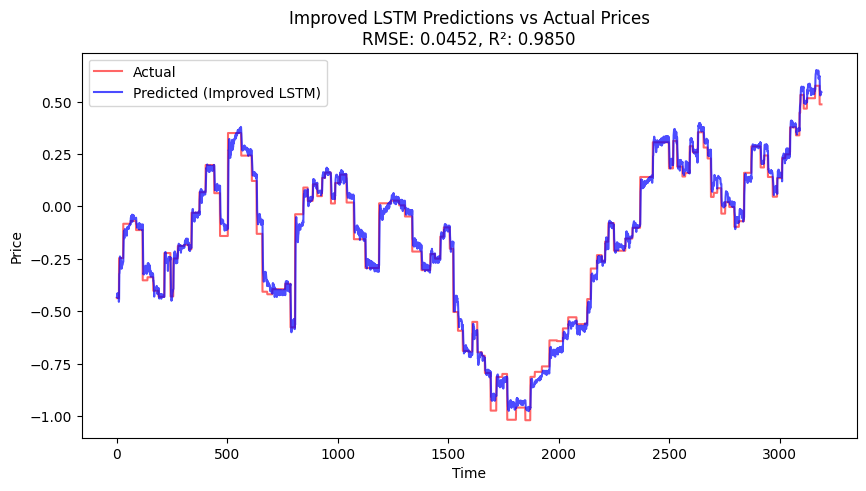

In [18]:



# Plot Actual vs Predicted Prices for Improved LSTM Model
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", color="red", alpha=0.6)
plt.plot(y_pred_lstm, label="Predicted (Improved LSTM)", color="blue", alpha=0.7)
plt.title(f"Improved LSTM Predictions vs Actual Prices\nRMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Splitting into Train, Validation, and Test Sets (70%-15%-15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshaping input data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Rebuilding the LSTM Model for Training with Validation Split
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

# Compiling with AdamW optimizer and lower learning rate
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# Training with validation set
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_data=(X_val_lstm, y_val), verbose=1)





Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.8604 - val_loss: 0.0644
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0954 - val_loss: 0.0328
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0551 - val_loss: 0.0237
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0422 - val_loss: 0.0194
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0402 - val_loss: 0.0165
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0357 - val_loss: 0.0140
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - val_loss: 0.0108
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0310 - val_loss: 0.0095
Epoch 9/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0287 - val_loss: 0.0107
Epoch 10/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282 - val_loss: 0.0100
Epoch 11/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0278 - val_loss: 0.0093
Epoch 12/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

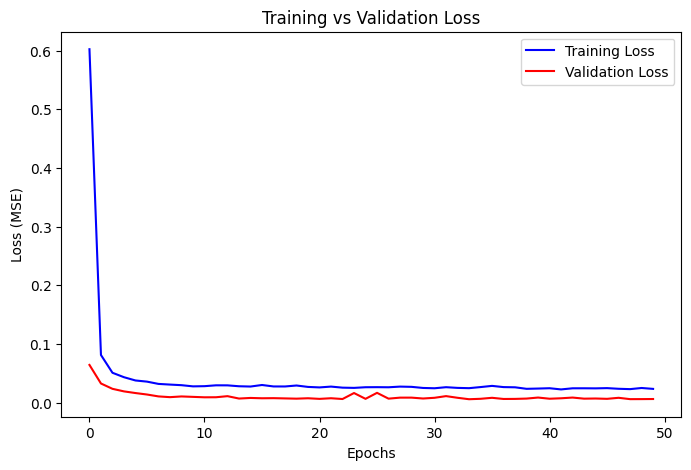

In [23]:

# Plot Training vs. Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [24]:
# Train and Test Predictions
y_train_pred = lstm_model.predict(X_train_lstm).flatten()
y_test_pred = lstm_model.predict(X_test_lstm).flatten()

# Compute R² Scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_r2, test_r2

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


(0.990719039128366, 0.987385729198274)

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Light GBM

In [9]:
# LightGBM Parameters
lgbm_params = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 10]
}

# XGBoost Parameters
xgb_params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0]
}

# Random Forest Parameters
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [10]:
# Instantiate models
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search for each model

# LightGBM Tuning
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
lgbm_search.fit(X_scaled, y_scaled.ravel())
best_lgbm = lgbm_search.best_estimator_

# XGBoost Tuning
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
xgb_search.fit(X_scaled, y_scaled.ravel())
best_xgb = xgb_search.best_estimator_

# Random Forest Tuning
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
rf_search.fit(X_scaled, y_scaled.ravel())
best_rf = rf_search.best_estimator_


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2239
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 10632, number of used features: 9[LightGBM] [Info] Number of data points in the train set: 10632, number of used features: 9

[LightGBM] [Info] Number of data

In [11]:

# Get best parameters
best_lgbm_params = lgbm_search.best_params_
best_xgb_params = xgb_search.best_params_
best_rf_params = rf_search.best_params_

best_lgbm_params, best_xgb_params, best_rf_params

({'num_leaves': 40, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1},
 {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1},
 {'n_estimators': 200,
  'min_samples_split': 10,
  'max_features': 'sqrt',
  'max_depth': 20})

In [8]:

ts_split = TimeSeriesSplit(n_splits=5)
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
X = df[feature_cols]
y = df["Close_next"]
train_index, test_index = list(ts_split.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [9]:

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


In [10]:

# Linear Regression
lr_model = LinearRegression()
lr_rmse, lr_r2, lr_pred = evaluate_model(lr_model, X_train, X_test, y_train, y_test)




In [11]:

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_rmse, rf_r2, rf_pred = evaluate_model(rf_model, X_train, X_test, y_train, y_test)


In [12]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_rmse, xgb_r2, xgb_pred = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)



In [13]:
# LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, max_depth=5, random_state=42)
lgbm_rmse, lgbm_r2, lgbm_pred = evaluate_model(lgbm_model, X_train, X_test, y_train, y_test)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 13290, number of used features: 9
[LightGBM] [Info] Start training from score 146.473215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [14]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_rmse, gb_r2, gb_pred = evaluate_model(gb_model, X_train, X_test, y_train, y_test)


In [15]:
# SVR
svr_model = SVR(kernel='rbf')
svr_rmse, svr_r2, svr_pred = evaluate_model(svr_model, X_train, X_test, y_train, y_test)


In [16]:

# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=30, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(np.expand_dims(X_test, axis=-1)).flatten()
lstm_rmse, lstm_r2 = sqrt(mean_squared_error(y_test, lstm_pred)), r2_score(y_test, lstm_pred)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [17]:

# Results Dictionary
results = {
    "LinearRegression": (lr_rmse, lr_r2, lr_pred),
    "RandomForest": (rf_rmse, rf_r2, rf_pred),
    "XGBoost": (xgb_rmse, xgb_r2, xgb_pred),
    "LightGBM": (lgbm_rmse, lgbm_r2, lgbm_pred),
    "GradientBoosting": (gb_rmse, gb_r2, gb_pred),
    "SVR": (svr_rmse, svr_r2, svr_pred),
    "LSTM": (lstm_rmse, lstm_r2, lstm_pred)
}

LinearRegression: RMSE = 0.6655, R² = 0.9941


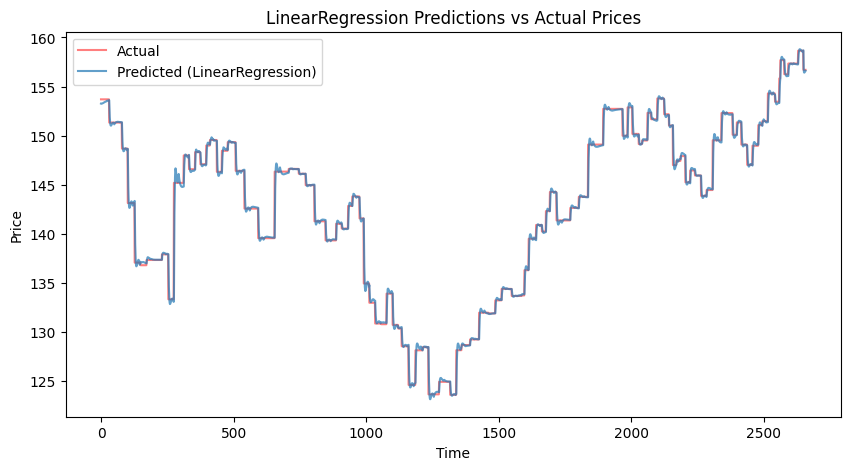

RandomForest: RMSE = 1.4601, R² = 0.9716


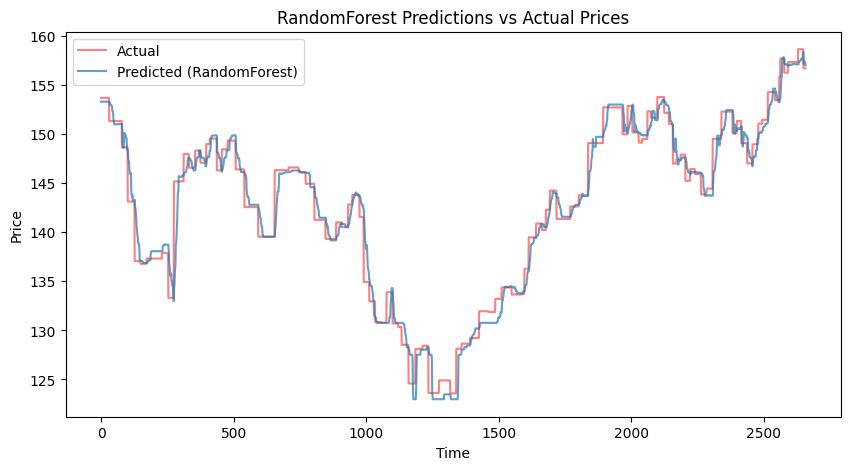

XGBoost: RMSE = 0.7948, R² = 0.9916


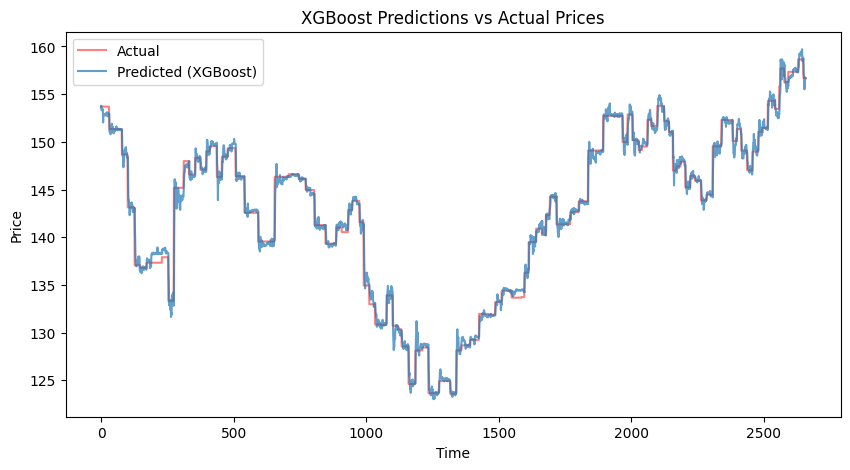

LightGBM: RMSE = 0.7220, R² = 0.9930


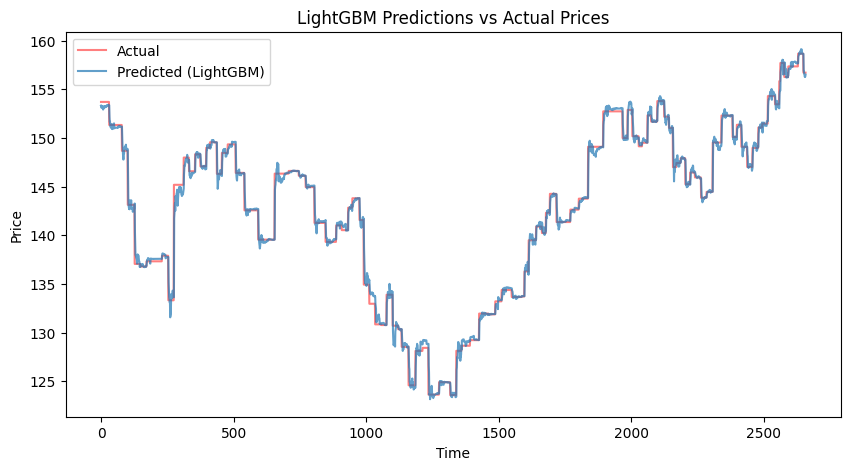

GradientBoosting: RMSE = 0.7563, R² = 0.9924


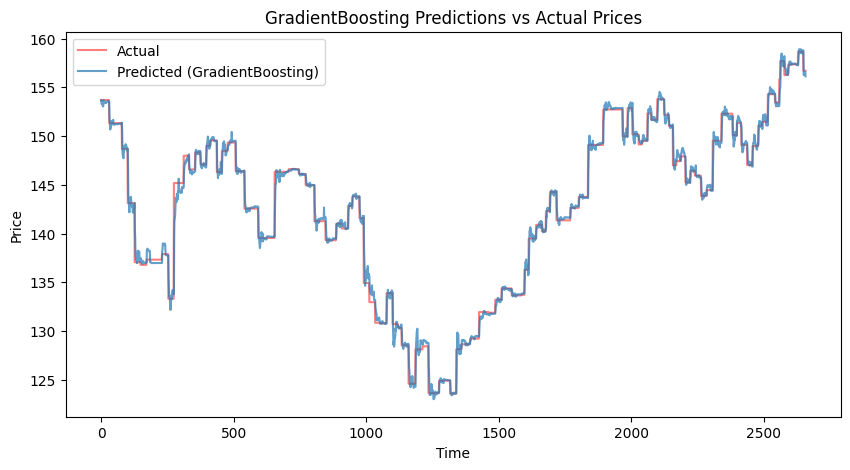

SVR: RMSE = 1.1837, R² = 0.9813


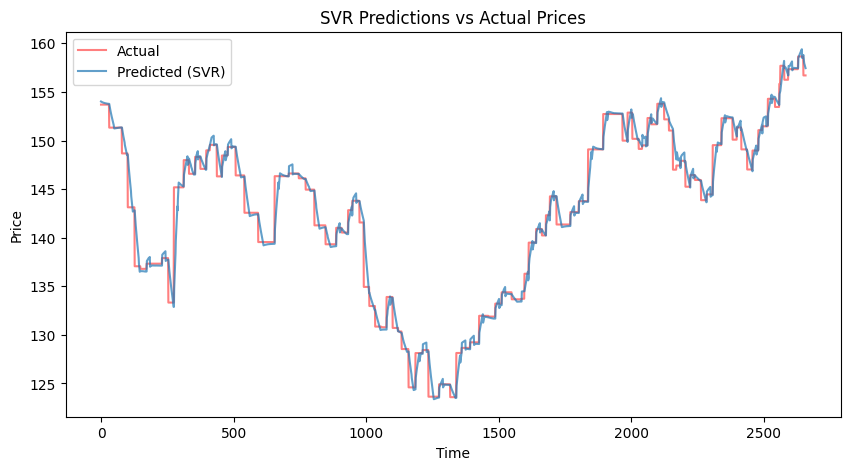

LSTM: RMSE = 9.7591, R² = -0.2701


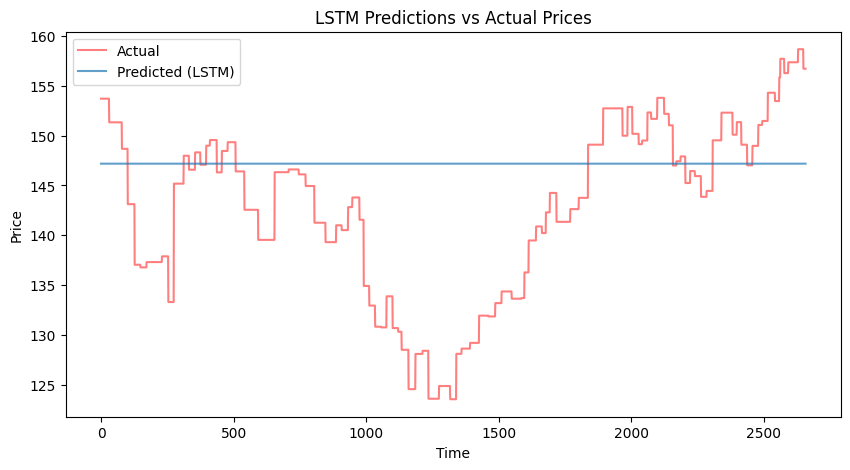

In [19]:


for model, (rmse, r2, y_pred) in results.items():
    print(f"{model}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values, label='Actual', color='red', alpha=0.5)
    plt.plot(y_pred, label=f'Predicted ({model})', alpha=0.7)
    plt.title(f"{model} Predictions vs Actual Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
